# 21 - Meta Learners
 
 
이제 치료 효과의 이질성 (크기) 를 찾는데 관심이 있습니다. 즉, 단위 데이터가 치료에 대해 어떻게 반응하는지 알아보고자 합니다. 이러한 관점에서, $\tau(x)$를 추정하길 원합니다.

 
$
\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]
$
 
연속일 경우, $E[\delta Y_i(t)|X]$. 다시 말해, 우리는 단위 데이터가 치료에 얼마나 민감한지 알고자 합니다. 이는 한정된 예산으로 모든 사람을 치료할 수 없어 우선순위를 정해야 할 때 매우 유용합니다. 앞에서는 변수 $Y$를 예측 모델 넣어 조건부 평균 치료 효과(CATE) 추정치를 얻을 수 있는 방법을 살펴보았습니다. There, we had to pay a price in terms of variance increase. 이는 데이터 사이언스에서 자주 보이는 현상입니다. 개별 방법은 각기 장단점이 있어 특정한 가장 좋은 방법은 없습니다. 상황에 적합한 방법을 선택할 수 있도록 다양한 기술을 배울 필요가 있습니다. 따라서 이 장에서는 여러분이 사용할 수 있는 다양한 도구를 제공하는 데 초점을 맞추었습니다.

![img](data/img/meta-learners/learned-new-move.png)  
[신난다! 데이터 사이언티스트는 인과 추론을 얻었다.]

Meta learner는 CATE 추정 문제를 해결하기 위해 기계 학습 방법을 활용하는 간단한 방법입니다. 다시 말하지만, 가장 좋은 하나는 특정할 수 없으며 개별 방법은 각각의 약점을 가집니다.

I'll try to go over them, but keep in mind that this stuff is highly dependent on the context. 뿐만 아니라 Meta leraner 는 선형 회귀, 결정 트리, 신경망, Gaussian process 등 다양한 ML 모델을 사용합니다. Meta learner의 성공 여부는 어떤 ML 방법을 사용하느냐에 따라 크게 달라집니다. 여러분은 많은 것을 시도하고 무엇이 가장 좋은지 살펴 보아야 합니다.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast

여기에서는 전과 동일한 투자 광고 메일 데이터를 사용합니다. 목표는 누가 이메일에 더 잘 응답할지 알아내는 것입니다. 이번에는 문제를 약간 바꿔 non-random 데이터로 모델을 학습하고 무작위 데이터로 검증해보겠습니다. 데이터의 편향을 제거하고 CATE를 추정해야 하기 때문에 non-random 데이터를 다루는 것은 훨씬 어려운 작업입니다.

In [2]:
test = pd.read_csv("./data/invest_email_rnd.csv")
train = pd.read_csv("./data/invest_email_biased.csv")
train.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,0,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,0,0,1,1
3,39.7,2326.37,15657.97,6345.20,0,0,0,0
4,35.3,2787.26,27074.44,14114.86,1,1,0,0


결과 변수는 $\textbf{converted}$ 이며, 처리(treatment)는 $\textbf{em1}$ 입니다. 치료 효과의 크기를 계산하기 위해 아래와 같이 변수를 지정합니다. $X$는 feature를 의미합니다.

In [3]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

## S-Learner
S-Learner는 생각할 수 있는 가장 간단한 방법입니다. S-Learner는 단일 ML 모델 $M_s$로 구성됩니다.

$
\mu(x) = E[Y| T, X]
$

치료 변수 $T$는 ML 모델의 feature로 포함되며, ML 모델은 $Y$를 반환합니다.

In [4]:
from lightgbm import LGBMRegressor

np.random.seed(123)
s_learner = LGBMRegressor(max_depth=3, min_child_samples=30)
s_learner.fit(train[X+[T]], train[y]);

그러면 $T$에 따라 예측값 $Y$를 예측할 수 있습니다. 실험군과 대조군 사이의 예측값 차이는 CATE 추정치가 됩니다.

$
\hat{\tau}(x)_i = M_s(X_i, T=1) - M_s(X_i, T=0)
$
 
도표로 표현하면 다음과 같습니다.
 
![img](data/img/meta-learners/s-learner.png)
 
이를 코드로 구현해 보겠습니다.

In [5]:
s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) - 
                        s_learner.predict(train[X].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X].assign(**{T: 0})))  # predict under control
)

모델을 평가하기 위해 검증 데이터에 대해 누적 이득 곡선을 살펴보겠습니다. 누적 이득 곡선에 훈련 데이터 결과를 함께 표기했습니다. 훈련 데이터는 편향되어 있기 때문에 이 곡선은 모델이 좋은지 알려주지 않습니다. 하지만 모델이 훈련데이터에 과적합 되었다는 사실은 확인할 수 있습니다. 과적합일 때 훈련 데이터의 곡선은 매우 높게 나타납니다. 과적합 곡선을 확인하고 싶다면 모델 파라미터 "max_depth" 를 3에서 20으로 바꿔보세요.

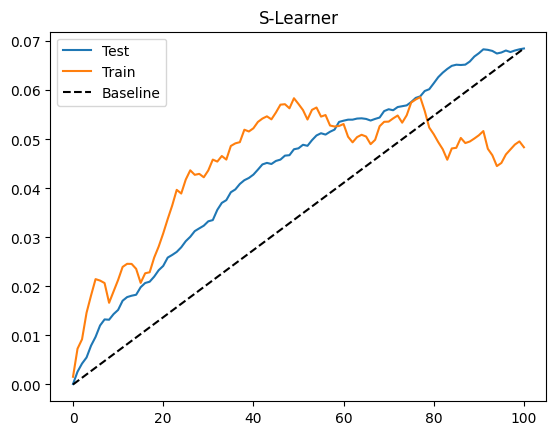

In [6]:
gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner");

![img](data/img/meta-learners/not-great-not-terrible.jpeg)
 
누적 이득 곡선에서 보이는 것 처럼, S-learner는 간단하지만 잘 동작합니다. 한 가지 명심해야 할 점은 이 성능은 이 데이터 셋에 특별히 잘 맞는 다는 사실입니다. 여러분이 가지고 있는 데이터에 따라 모델의 성능은 더 좋을 수도, 더 나쁠 수도 있습니다. 단순한 S-learner 특성상 인과적 문제에 대해 가장 먼저 시도해볼 만한 모델로 보입니다. 또한, S-learner는 $T$가 연속 변수, 이산 변수 일때 모두 적용할 수 있는 장점이 있습니다. 반면 다른 meta learner 는 이산 변수에만 다룰 수 있습니다.  

S-learner의 가장 큰 단점은 치료 효과를 zero-center 로 편향시키는 것 입니다. S-learner는 일반적으로 정규화된 ML 모델을 사용하기 때문에 추정 치료 효과를 제한할 수 있습니다. [Chernozhukov et al (2016)](https://arxiv.org/abs/1608.00060) 에서 시뮬레이션 데이터로 이 문제를 다룬 바 있습니다.
 
![img](data/img/meta-learners/zero-bias-s-learner.png)
 
위 그림은 S-learner를 사용한 실제 인과 효과(빨간색)와 추정 인과 효과 $\tau-\hat{\tau}$ 의 차이를 나타냅니다. 
추정 인과 효과는 대부분 하향 편향 ($\tau - \hat{\tau} > 0$) 되어 있습니다. 즉, 실제 인과 효과는 추정값 보다 큰 경향이 있습니다.  

설상가상으로, 치료 변수 $T$의 효과가 다른 변수 $X$에 비해 출력 $Y$에 미치는 영향이 작은 경우 S-learner는 치료 변수 $T$를 완전히 버릴 가능성이 있습니다. 이는 선택한 ML 모델에 따라 매우 달라집니다. 정규화가 클수록 문제가 커집니다. 이 문제를 해결하기 위해 T-learner를 살펴보겠습니다.

## T-Learner
 
T러너 The T-learner tries to solve the problem of discarding the treatment entirely by forcing the learner to first split on it. Instead of using a single model, we will use one model per treatment variable. In the binary case, there are only two models that we need to estimate (hence the name T):
 
$
\mu_0(x) = E[Y| T=0, X]
$
 
$
\mu_1(x) = E[Y| T=1, X]
$
 
Then, at prediction time, we can make counterfactual predictions for each treatment and get the CATE as follows.
 
$
\hat{\tau}(x)_i = M_1(X_i) - M_0(X_i)
$
 
Here is the diagram of this learner
 
![img](data/img/meta-learners/t-learner.png)


Now, enough about theory. Let's code this up.

In [7]:
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

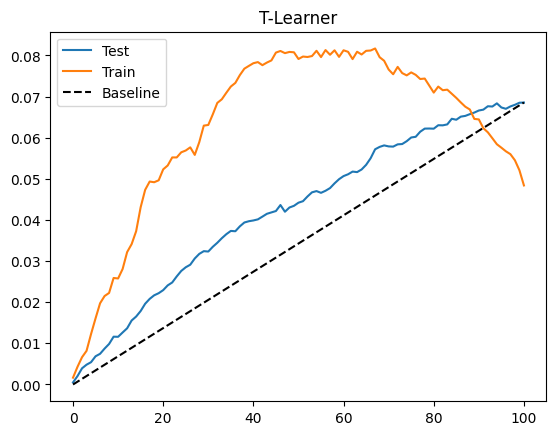

In [8]:
gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("T-Learner");

The T-learner also performs OK on this dataset. The test performance doesn't look much different from what we got with the S-learner. Perhaps because the treatment is not that weak. Also, we can see that the training performance is much higher than the testing performance. This indicates the model is overfitting. This can happen because we are fitting each model on only a subset of the data. With less data points, the model is probably learning some noise. 
 
The T-Learner avoids the problem of not picking up on a weak treatment variable, but it can still suffer from regularization bias. Consider the following situation, taken from Kunzela et al, 2019. You have lots of data for the untreated and very few data for the treated, a pretty common case in many applications, as treatment is often expensive. Now suppose you have some non linearity in the outcome Y, but the **treatment effect is constant**. We can see what happens in the following image
 
![img](data/img/meta-learners/t-learner-problem.png)
 
Here, since we have very few treated observations, $M_1$ will be a very simple model (linear in this case) to avoid overfitting. $M_0$ will be more complicated, but that's OK because the abundance of data prevents overfitting. This is all reasonable from a Machine Learning perspective. However, if we use these models to compute the cate $\hat{\tau}=M_1(X) - M_0(X)$, the linearity of $M_1(X)$ minus the non linearity of $M_0(X)$ will result in a nonlinear CATE (blue line minus red line), which is wrong, since the CATE is constant and equal to 1 in this case. 
 
What happens here is that the model for the untreated can pick up the non linearity, but the model for the treated cannot, because we've used regularization to deal with a small sample size. Of course, you could use less regularization on that model, but then the small sample size will cause you to overfit. Seems like we are caught between a rock and a hard place. To solve this problem, we can use an X-learner, proposed in the same paper by Kunzela et al. 

## X-Learner
 
The X-learner is significantly more complex to explain than the previous learner, but its implementation is quite simple, so don't worry. The X-Learner has two stages and a propensity score model. The first one is identical to the T-learner. First, we split the samples into treated and untreated and fit a ML model for the treated and for control.
 
$
\hat{M}_0(X) \approx E[Y| T=0, X]
$
 
$
\hat{M}_1(X) \approx E[Y| T=1, X]
$
 
Now, things start to take a turn. For the second stage, we input the treatment effect for the control and for the treated using the models above
 
$
\hat{\tau}(X, T=0) = \hat{M}_1(X, T=0) - Y_{T=0}
$
 
$
\hat{\tau}(X, T=1) = Y_{T=1} - \hat{M}_0(X, T=1)
$
 
Then, we fit two more models to predict those effects
 
$
\hat{M}_{\tau 0}(X) \approx E[\hat{\tau}(X)|T=0]
$
 
$
\hat{M}_{\tau 1}(X) \approx E[\hat{\tau}(X)|T=1]
$
 
If we apply this on the image we've shown before, $\hat{\tau}(X, T=0)$, the imputed treatment effect on the untreated, would be the red crosses and the red dashed line would be $\hat{M}_{\tau 0}(X)$. Notice that this model is wrong. Because $\hat{\tau}(X, T=0)$ was made using the regularized, simple model, estimated on the treated, $\hat{M}_1$.  The treatment effect it inputs is non linear, since it **doesn't** capture the non-linearity in the Y variable.
 
In contrast, the blue dots are the imputed treatment effect for the treated, $\hat{\tau}(X, T=1)$. These effects are estimated using the correct model, $M_0$, trained in the untreated, large, sample. As a result, since its imputed treatment effects are correct, we are able to train a correct second stage model $\hat{M}_{\tau 1}(X)$, shown by the blue line. 
 
![img](data/img/meta-learners/second-stage-x.png)
 
So we have one model that is wrong because we've input the treatment effects wrongly and another model that is correct because we've imputed those values correctly. Now, we need a way to combine the two in a way that gives more weight to the correct model. Here is where the propensity score model comes to play. Let $\hat{e}(x)$ be the propensity score model, we can combine the two second stage models as follows:
 
$
\hat{\tau(x)} = \hat{M}_{\tau 0}(X)(\hat{e}(x)) +  \hat{M}_{\tau 1}(X)(1-\hat{e}(x))
$
 
Since there are very few treated units, $\hat{e}(x)$ is very small. This will give a very small weight to the wrong model $\hat{M}_{\tau 0}(X)$. 

In contrast, $1-\hat{e}(x)$ is close to one, so we will give a high weight to the correct model $\hat{M}_{\tau 1}(X)$. More generally, weighted average using the propensity score will make sure we give more weight to the CATE model that was estimated where the assigned treatment was more likely. In other words, we will favor the model that was trained using more data. The following image shows the estimated CATE given by the X-learner and the T-learner.
 
![img](data/img/meta-learners/t-vs-x-learner.png)
 
As we can see, compared to the T-learner, the X-learner does a much better job in correcting the wrong CATE estimated at the non linearity. In general the X-learner performs better when a treatment group is much larger than the other. 
 
I know this might be a mouthful, but it will hopefully be clear once we move to the implementation. Just to summarize everything, here is the diagram of this learner.
 
![img](data/img/meta-learners/x-learner.png)
 
To the code at last! First, we have the first stage, which is exactly the same as the T-Learner. 

In [9]:
from sklearn.linear_model import LogisticRegression

np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty='none') 

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])
                       
g.fit(train[X], train[T]);

Now, we impute the treatment effect and fit the second stage models on them. 

In [10]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0]);
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1]);

Finally, we make corrected predictions using the propensity score model. 

In [11]:
def ps_predict(df, t): 
    return g.predict_proba(df[X])[:, t]
    
    
x_cate_train = (ps_predict(train,0)*mx0.predict(train[X]) +
                ps_predict(train,1)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test,0)*mx0.predict(test[X]) +
                                ps_predict(test,1)*mx1.predict(test[X])))

Lets see how our X-Learner does in the test. Again, let's plot the cumulative gain curve. 

Text(0.5, 1.0, 'X-Learner')

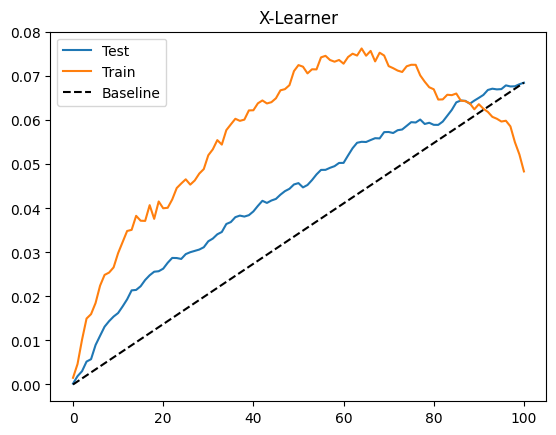

In [12]:
gain_curve_test = cumulative_gain(x_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("X-Learner")

Once more, we have an OK performance on this dataset. Here, the S, T and X learners seem to perform pretty similarly. Still, I think it is worth knowing about all these meta learners so you can use whatever works best for you. Keep in mind that the performance is also highly dependent on the base machine learning model we choose. Here, we did everything using Gradient Boosted Trees, but maybe something else or even the same thing with different hyperparameters might work better. 
 
## Key Ideas
 
Again, the simplest thing we can do is using a single or S-learner with the treatment as a feature. This tends to work well when the treatment is not a weak predictor of the outcome. But if that's not the case, the S-learner tends to be biased towards zero or even drop the treatment entirely. Adding a bit more complexity, we can force the learner to pick up the treatment by using a T-learner. Here, we fit one Machine Learning model per treatment level. This works fine when there are enough samples for all treatment levels, but it can fail when one treatment level has a small sample size, forcing a model to be heavily regularized. To fix that, we can add another level of complexity using an X-learner, where we have two fitting stages and we use a propensity score model to correct potential mistakes from models estimated with very few data points.
 
One big problem of these learners (except the S-learner) is that they assume a binary or categorical treatment. There is one additional learner that we haven't seen yet, which is more general: the R-learner. But don't worry, we will have an entire chapter dedicated to it. 
 
## References 
 
The things I've written here are mostly stuff from my head. I've learned them through experience. This means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.
 
To write this chapter, I've relied on Uber's *causalml* library and their documentation on meta learners. I've also took a lot of images and concept from Kunzela et al (2019), *Metalearners for estimating heterogeneous treatment effects using machine learning*. Finally, the discussion on the S-learner being biased towards zero was taken from Chernozhukov et al (2017), *Double/Debiased Machine Learning for Treatment and Causal Parameters*.
 
## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).